In [152]:
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import json
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 14
from IPython.display import Image

Module for computations

In [153]:
import FEM_utilities as FEM

Parameters:

In [154]:
a = 1000. # lenght [mm]
b = 200.  # width  [mm]
t = 1.5   # thickness [mm]


Compute node coordinates, elements, constrained and loaded nodes

In [155]:
nx = 40
ny = 8

nodes, elements, fixed, loaded = FEM.Nodes(nx, ny, a, b)

In [156]:
#nodes

In [157]:
#elements

In [158]:
#fixed

In [159]:
#loaded

## Write input file

Set parameters for simulation:

- *filename* : name of input file
- *eltype* : type of shell element (see conventions [here](http://media.3ds.com/support/documentation/product/V6R2013/en/English/MpeUsbHtml/pt06ch29s06alm17.htm))
- *matname*: name of material
- **E**, $\nu$: elastic properties (Young modulus and Poisson ratio, as *TYPE* is by default **isotropic**) 
- *elname*: **\*Elset** assigned name
- *bcname*, *loadextname*, *loadintname*: names for boundary condition, external and internal nodes loaded 
- *pa*, *pb*,*ax*, $\alpha$: coordinate points, axis and angle used to define local coordinate system (see conventions [here](http://media.3ds.com/support/documentation/product/V6R2013/en/English/MpeKeyHtml/ch15abk01.htm#usb-kws-morientation)) 
- *intpoints*: shell integration points
- *F*: force at tip of plate [N/mm]

In [160]:
basename = 'test_'+str(nx)+'x'+str(ny)+'y'

filename = basename+'.inp'

eltype = 'S4R' #'SC8R'

matname = 'material_1'

E = 72000. # modulus [MPa]
ν = 0.33   # Poisson's coefficient

elname = 'plate_1'

bcname = 'fixed_nodes'
loadextnodes = 'loaded_nodes_external'
loadintnodes = 'loaded_nodes_internal'

pa = [1.0,0.0,0.0]
pb = [0.0,1.0,0.0]
# pc = [0.0,0.0,0.0]
ax = 3
α = 0.0

intpoints = 5

F = 0.02   # load [N/mm]

In [161]:
outfile = open(filename, "wt")

outfile.write("** Lab 02 input file test\n")

# NODES section

outfile.write("**\n")
outfile.write("** NODES\n")
outfile.write("**\n")
outfile.write("*Node, nset = nglobal\n")

for i in range(nodes.shape[0]):
    nodestring = "{0:4d}".format(int(nodes[i,0]))
    for j in range(1,nodes.shape[1]):
        nodestring+=",{0:8}".format(nodes[i,j])
    nodestring+="\n"
    outfile.write(nodestring)

# ELEMENTS section
    
outfile.write("**\n")
outfile.write("** ELEMENTS\n")
outfile.write("**\n")
outfile.write("*Element, type = {0}\n".format(eltype))

for i in range(elements.shape[0]):
    elstring = "{0:4d}".format(int(elements[i,0]))
    for j in range(1,elements.shape[1]):
        elstring+=",{0:4d}".format(int(elements[i,j]))
    elstring+="\n"
    outfile.write(elstring)

# MATERIAL section

outfile.write("**\n")
outfile.write("** MATERIALS\n")
outfile.write("**\n")
outfile.write("*Material, name = {0}\n".format(matname))
outfile.write("*Elastic\n")
outfile.write("{0},{1:6}\n".format(E,ν))

# SETS section
# NODES

outfile.write("**\n")
outfile.write("** SETS\n")
outfile.write("**\n")
outfile.write("*Nset, nset = {0}\n".format(bcname))

fix_str = "{0:4d}".format(int(fixed[0]))

for i in range(1,len(fixed)):
    fix_str+=",{0:4d}".format(int(fixed[i]))
fix_str+="\n"
outfile.write(fix_str)

if len(loaded > 2):
    outfile.write("*Nset, nset = {0}\n".format(loadintnodes))
    il_str = "{0:4d}".format(int(loaded[1]))
    for i in range(2,len(loaded)-1):
        il_str+=",{0:4d}".format(int(loaded[i]))
    il_str+="\n"
    outfile.write(il_str)
    
outfile.write("*Nset, nset = {0}\n".format(loadextnodes))
el_str = "{0:4d},{1:4d}\n".format(int(loaded[0]),int(loaded[-1]))
outfile.write(el_str)

# ELEMENTS
outfile.write("*Elset, elset = {0}, generate\n".format(elname))
outfile.write("{0:4d},{1:4d},{2:4d}\n".format(1,elements.shape[0],1))

# ORIENTATION

outfile.write("**\n")
outfile.write("** LOCAL ORIENTATION\n")
outfile.write("**\n")
outfile.write("*orientation, name = local_orientation\n")
outfile.write("".join(str(pa+pb))[1:-1])
outfile.write("\n")
outfile.write("{0},{1:4}\n".format(ax,α))

# SHELL PROPERTIES
outfile.write("**\n")
outfile.write("** SHELL PROPERTIES\n")
outfile.write("**\n")
outfile.write("*Shell Section, elset = {0}, material = {1}, orientation = local_orientation\n" \
              .format(elname,matname))
outfile.write("{0:4},{1:4d}\n".format(t,intpoints))

# calculation steps
outfile.write("**\n")
outfile.write("** STEP\n")
outfile.write("**\n")

outfile.write("*Step, name = step_1\n")
outfile.write("*Static\n")

# BOUNDARY CONDITIONS

outfile.write("**\n")
outfile.write("** BOUNDARY CONDITIONS\n")
outfile.write("**\n")
outfile.write("*Boundary\n")
outfile.write("{0}, ENCASTRE\n".format(bcname))

# LOADS

outfile.write("**\n")
outfile.write("** LOADS\n")
outfile.write("**\n")
outfile.write("*Cload\n")
outfile.write("{0}, {1:2d}, {2}\n".format(loadextnodes, 3, F*b/ny/2 ))
outfile.write("{0}, {1:2d}, {2}\n".format(loadintnodes, 3, F*b/ny ))

# FIELD OUTPUT

outfile.write("**\n")
outfile.write("** FIELD OUTPUT\n")
outfile.write("**\n")
outfile.write("*Output, field, variable=PRESELECT\n")

# HISTORY OUTPUT

outfile.write("**\n")
outfile.write("** HISTORY OUTPUT\n")
outfile.write("**\n")
outfile.write("*Output, history, variable=PRESELECT\n")

# PRINT DISPLACEMENT AND STRESS DATA

outfile.write("**\n")
outfile.write("** PRINT RESULTS TO FILE\n")
outfile.write("**\n")
outfile.write("*NODE FILE\n")
outfile.write("U,\n")
outfile.write("RF,\n")
outfile.write("*EL FILE\n")
outfile.write("S,\n")


outfile.write("*End Step\n\n")

outfile.close()


copy file to analysis directory

In [162]:
if not os.path.exists('../Lab02_abaqus/'+basename):
    os.makedirs('../Lab02_abaqus/'+basename)

shutil.copy(filename,'../Lab02_abaqus/'+basename)

'../Lab02_abaqus/test_40x8y/test_40x8y.inp'

## Analytical solutions:

Maximum stress at $x = 350 mm$:

$\sigma_{xx} = \frac{(a-x) \cdot F}{\frac{1}{12}\cdot bt^3} \cdot \frac{t}{2} = \frac{6 \cdot f \cdot (a-x)}{t^2}$



In [163]:
σ = 6*F*(a-350)/t**2
print("σ max = %6.3f MPa" % σ)

σ max = 34.667 MPa


Tip displacement:

$$\delta = \frac{F \cdot a^3}{3 \cdot EI} = \frac{4 \cdot f \cdot l^3}{E \cdot t^3}$$

In [164]:
δ = 4*F*a**3/(E*t**3)
print("δ = %7.2f mm" % δ)

δ =  329.22 mm


# $\sigma_{11} @\ 350mm$

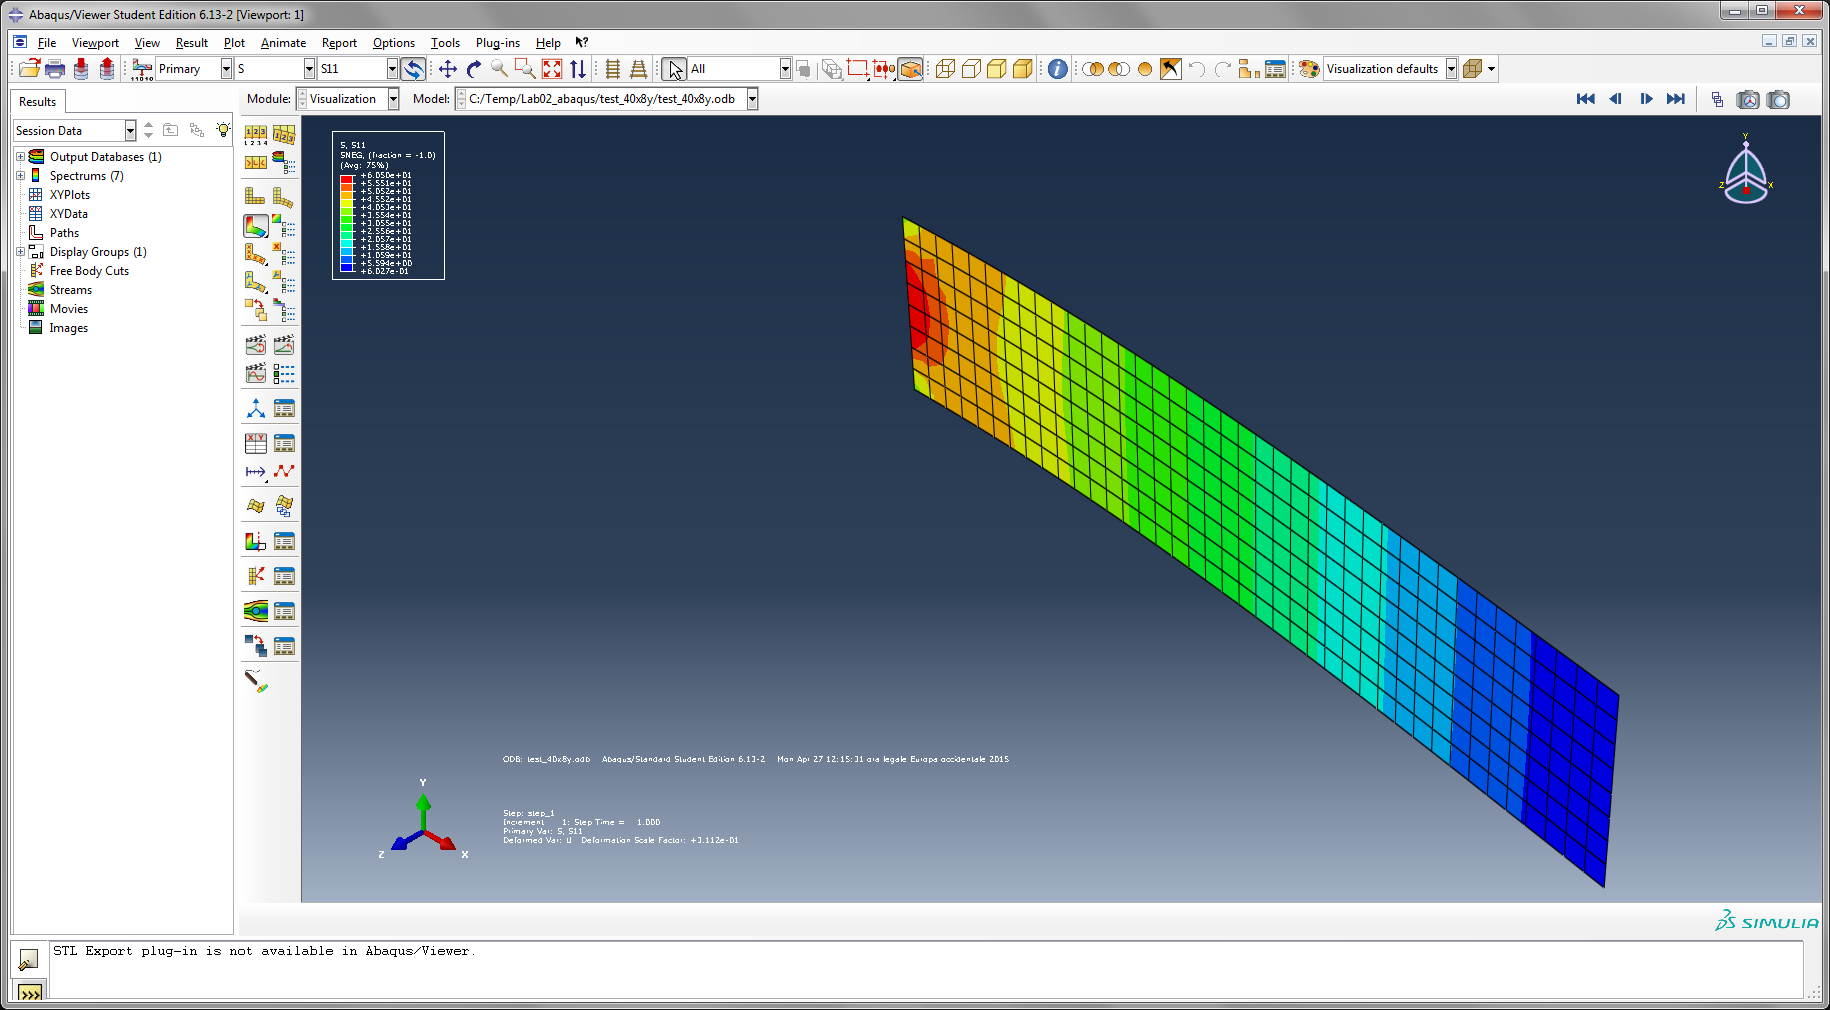

In [165]:
Image(filename='../Lab02_abaqus/'+basename+'/S11.png')

In [166]:
S11_file = open('../Lab02_abaqus/'+basename+'/'+basename+'_S11.rpt')

In [167]:
S11_array = np.zeros(ny)

nodes = [int(y*nx+7./20.*nx) for y in range(ny)]

#print(nodes)

rows = S11_file.readlines()

i_array = 0

for line in rows:
    data = line.split()
    if len(data)==4 and data[0].isdigit():
        if int(data[0]) in nodes:
            S11_array[i_array] = float(data[2])
            i_array += 1
        
#print(S11_array)

In [168]:
S11_array

array([ 35.3893,  35.3446,  35.3096,  35.2899,  35.2899,  35.3096,
        35.3446,  35.3893])

#Tip displacement

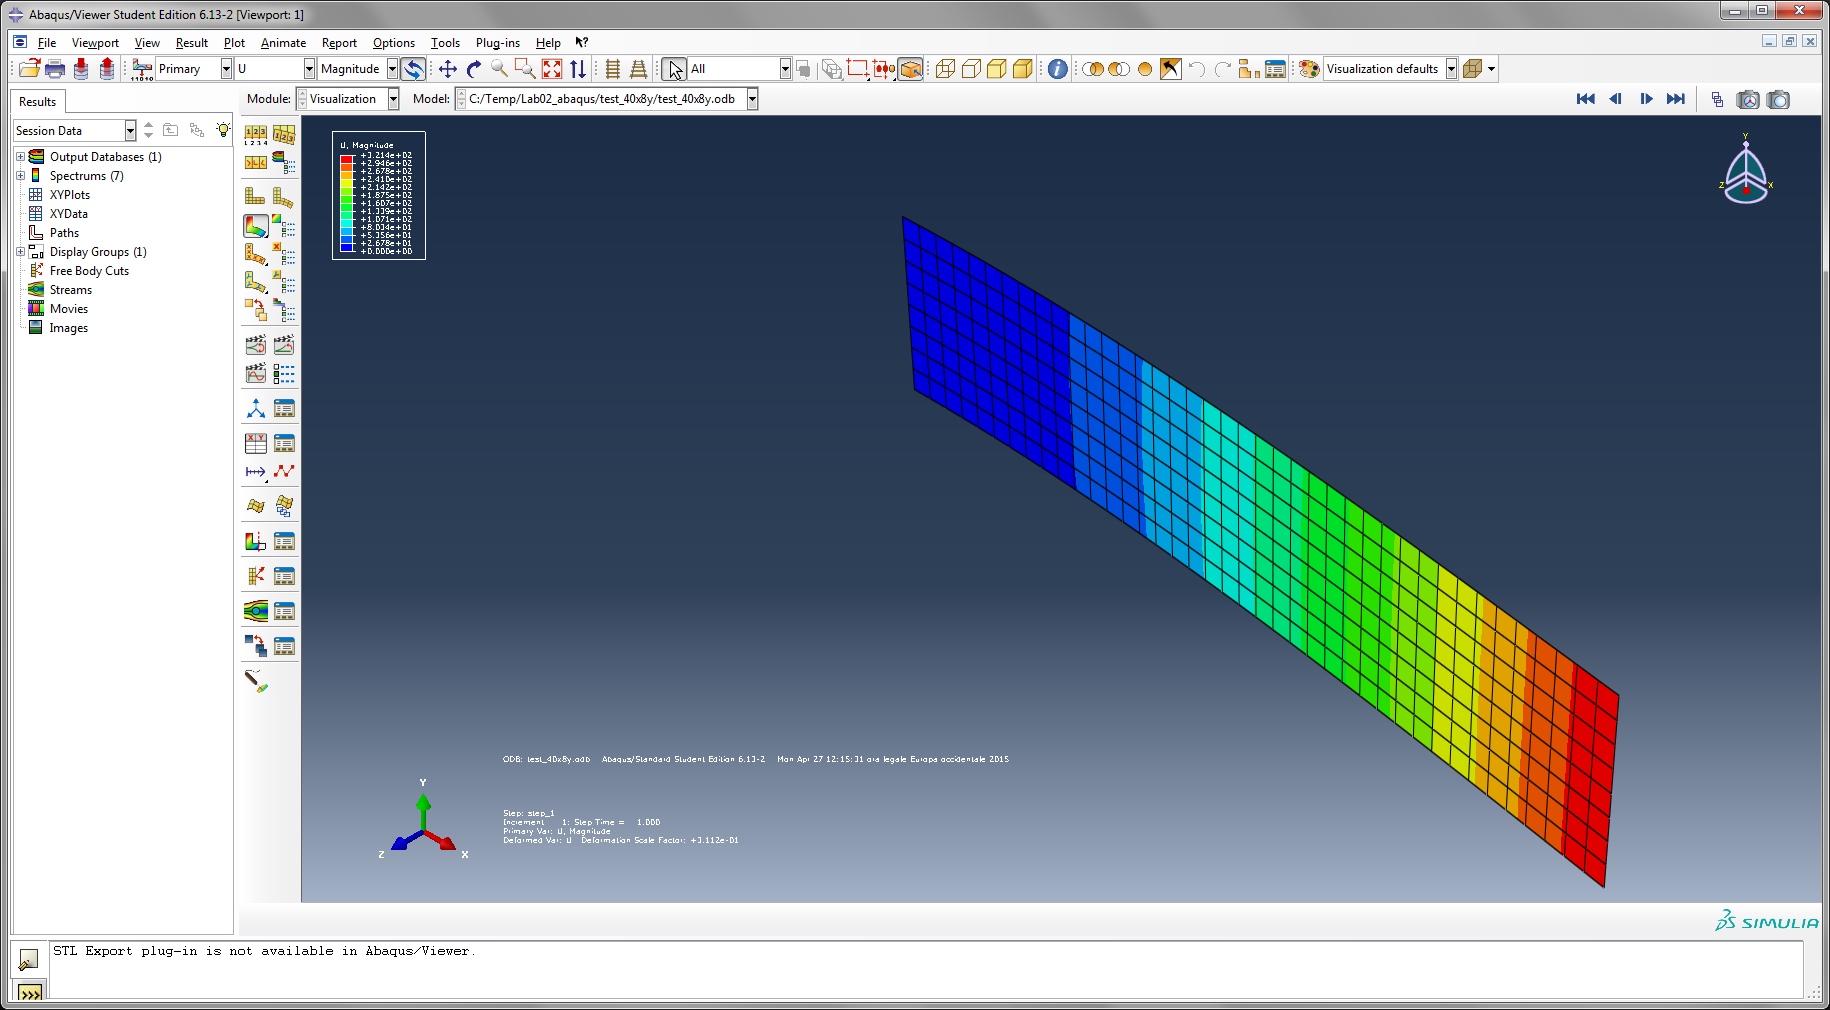

In [169]:
Image(filename='../Lab02_abaqus/'+basename+'/Um.png')